# Stock Price Prediction

-




by Marie & Tea 




-

In [2]:
# Bibliotheken importieren
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import SimpleRNN
from keras.models import load_model
import keras
import h5py
import requests
import os

<ipython-input-2-b401c377861b>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Arbeitspaket 1: Datenvisualisierung

### Get Data

In [3]:
# csv einlesen
df_aapl = pd.read_csv('AAPL.csv')
df_t = pd.read_csv('T.csv')

In [4]:
# erste paar Zeilen anschauen Apple
df_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,27.767500,27.997499,27.200001,27.834999,25.578905,224954000
1,2015-12-17,28.004999,28.062500,27.245001,27.245001,25.036730,179091200
2,2015-12-18,27.227501,27.379999,26.452499,26.507500,24.359007,385813200
3,2015-12-21,26.820000,26.842501,26.392500,26.832500,24.657661,190362400
4,2015-12-22,26.850000,26.930000,26.612499,26.807501,24.634689,131157600


In [5]:
# erste paar Zeilen anschauen AT&T
df_t.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,33.910000,34.480000,33.900002,34.400002,25.919930,31192700
1,2015-12-17,34.419998,34.610001,34.029999,34.029999,25.641140,27720500
2,2015-12-18,33.869999,34.000000,33.599998,33.599998,25.317139,51216300
3,2015-12-21,33.919998,34.110001,33.750000,34.090000,25.686344,20392400
4,2015-12-22,34.290001,34.480000,34.009998,34.410000,25.927462,20427300


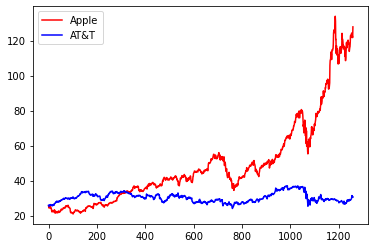

In [31]:
# Apple Aktienverlauf und AT&T Aktienverlauf vergleichen
# Code ist von unten aus dem Beispiel zur Visualisierung des vorhergesagten Aktienpreises
plt.plot(df_aapl['Adj Close'],color='red', label='Apple')
plt.plot(df_t['Adj Close'],color='blue', label='AT&T')
plt.legend(loc='best')
plt.show()

### Profit per day 

### Max & Min Stock Value 

#### Wann einsteigen damit sich Aktienwert verdoppelt (Apple)?

Bei Apple passt da fast jedes Datum bis Ende 2019 (siehe Diagramm).

### Plot Stock Volume Evolution

## Arbeitspaket 2: Datenaufbereitung

Prediction Goal: 
- Adj Close

Features:
- (Date)
- Open 
- High
- Low
- Adj Close

### Load CSV

### Normalize Data

In [7]:
# Da man diesen Code mehrmals braucht macht es Sinn ihn als Methode
# zu verpacken

# Daten normalisieren (zwishen -1 und 1 bringen)
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    # Volumen brauchen wir nicht, da nicht gefragt
    #df['Volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

### Load Data

In [8]:
# Daten vorbereiten - 
# Sliding Window 
# Split in Training und Test Daten
def load_data(stock, seq_len): 
    
    amount_of_features = len(stock.columns) 
    #data = stock.as_matrix()
    data = stock.values
    
    
    sequence_length = seq_len + 1 
    result = []
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) 
    train = result[:int(row), :] 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

### Prepare Apple Data

In [9]:
# Apple csv einlesen
df_apple = pd.read_csv('AAPL.csv', index_col = 0)
# Feature Volume entfernen
df_apple.drop(['Volume'], 1, inplace=True)
# Feature Close entfernen
df_apple.drop(['Close'], 1, inplace=True)

df_apple.head()

,Open,High,Low,Adj Close
Date,,,,
2015-12-16,27.767500,27.997499,27.200001,25.578905
2015-12-17,28.004999,28.062500,27.245001,25.036730
2015-12-18,27.227501,27.379999,26.452499,24.359007
2015-12-21,26.820000,26.842501,26.392500,24.657661
2015-12-22,26.850000,26.930000,26.612499,24.634689


In [10]:
df_apple = normalize_data(df_apple)
df_apple.head()

,Open,High,Low,Adj Close
Date,,,,
2015-12-16,0.045769,0.044150,0.044678,0.040590
2015-12-17,0.047832,0.044715,0.045094,0.035790
2015-12-18,0.041077,0.038783,0.037767,0.029790
2015-12-21,0.037536,0.034112,0.037213,0.032434
2015-12-22,0.037797,0.034872,0.039246,0.032231


### Prepare AT&T Data

In [11]:
# AT&T csv einlesen
df_att = pd.read_csv('T.csv', index_col = 0)
# Feature Volume entfernen
df_att.drop(['Volume'], 1, inplace=True)
# Feature Close entfernen
df_att.drop(['Close'], 1, inplace=True)
df_att.head()

,Open,High,Low,Adj Close
Date,,,,
2015-12-16,33.910000,34.480000,33.900002,25.919930
2015-12-17,34.419998,34.610001,34.029999,25.641140
2015-12-18,33.869999,34.000000,33.599998,25.317139
2015-12-21,33.919998,34.110001,33.750000,25.686344
2015-12-22,34.290001,34.480000,34.009998,25.927462


In [12]:
df_att = normalize_data(df_att)
df_att.head()

,Open,High,Low,Adj Close
Date,,,,
2015-12-16,0.435882,0.446796,0.453333,0.140581
2015-12-17,0.465882,0.454439,0.460869,0.119136
2015-12-18,0.433529,0.418577,0.435942,0.094212
2015-12-21,0.436470,0.425044,0.444638,0.122613
2015-12-22,0.458235,0.446796,0.459710,0.141160


### Denormalize Data

In [13]:
# Daten denormalisieren, damit wieder USD Werte entstehen
def denormalize(df, normalized_value): 
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    min_max_scaler = MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

### Evaluate Model

In [14]:
# Das Model (RNN oder LSTM) evaluieren
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

## Arbeitspaket 3: RNN

### Build Model

In [15]:
# Hier wird das neuronale Netz mit seinen Schichten gebaut
def build_model_rnn(layers):
    d = 0.3
    model = Sequential()
    
    # LSTM durch SimpleRNN ersetzt (siehe Quelle)
    model.add(SimpleRNN(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    # LSTM durch SimpleRNN ersetzt (siehe Quelle)
    model.add(SimpleRNN(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [16]:
# window haben wir einfach aus dem Beispiel übernommen
window = 22
# Methode von oben aufrufen
X_train, y_train, X_test, y_test = load_data(df_apple, window)
print (X_train[0], y_train[0])

[[0.04576853 0.04414991 0.04467816 0.04058979]
 [0.04783212 0.04471483 0.0450942  0.03578986]
 [0.04107656 0.03878326 0.03776724 0.02978991]
 [0.03753584 0.03411191 0.03721253 0.03243393]
 [0.03779651 0.03487235 0.0392465  0.03223055]
 [0.03751411 0.03732754 0.04098    0.03503731]
 [0.04127205 0.03765345 0.0427135  0.03385764]
 [0.03820922 0.03480718 0.03862244 0.03139665]
 [0.03684073 0.03858773 0.04019415 0.03530169]
 [0.04035972 0.03700162 0.04093378 0.03241357]
 [0.03694935 0.03337317 0.03547902 0.02822379]
 [0.02739161 0.02976644 0.02896105 0.02840686]
 [0.03421236 0.03080934 0.02990871 0.02303741]
 [0.02293856 0.02324824 0.02403792 0.0189493 ]
 [0.01885481 0.01838131 0.01608691 0.01030525]
 [0.01857243 0.01616513 0.01684966 0.01134261]
 [0.01948475 0.01605648 0.01819021 0.01453578]
 [0.02291686 0.01959805 0.02165722 0.01744421]
 [0.02241724 0.02068442 0.01809778 0.01221712]
 [0.01729082 0.01914178 0.01449207 0.01654927]
 [0.01346771 0.0131233  0.01361378 0.01168829]
 [0.01826832 

In [17]:
# Methode von oben aufrufen
model_rnn = build_model_rnn([4,window,1]) 

Compilation Time :  0.005764961242675781


### Fit Model

In [18]:
model_rnn.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Epoch 1/90
2/2 [==============================] - 2s 704ms/step - loss: 0.0328 - accuracy: 6.6667e-04 - val_loss: 0.0557 - val_accuracy: 0.0000e+00
Epoch 2/90
2/2 [==============================] - 0s 140ms/step - loss: 0.0073 - accuracy: 6.6667e-04 - val_loss: 0.1378 - val_accuracy: 0.0000e+00
Epoch 3/90
2/2 [==============================] - 0s 144ms/step - loss: 0.0215 - accuracy: 6.6667e-04 - val_loss: 0.0340 - val_accuracy: 0.0000e+00
Epoch 4/90
2/2 [==============================] - 0s 142ms/step - loss: 0.0071 - accuracy: 0.0013 - val_loss: 0.0674 - val_accuracy: 0.0000e+00
Epoch 5/90
2/2 [==============================] - 0s 144ms/step - loss: 0.0050 - accuracy: 0.0013 - val_loss: 0.0741 - val_accuracy: 0.0000e+00
Epoch 6/90
2/2 [==============================] - 0s 142ms/step - loss: 0.0049 - accuracy: 0.0013 - val_loss: 0.0411 - val_accuracy: 0.0000e+00
Epoch 7/90
2/2 [==============================] - 0s 140ms/step - loss: 0.0034 - accuracy: 6.6667e-04 - val_loss: 0.0346 - v

2/2 [==============================] - 0s 141ms/step - loss: 3.0511e-04 - accuracy: 0.0013 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 56/90
2/2 [==============================] - 0s 142ms/step - loss: 2.8149e-04 - accuracy: 6.6667e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 57/90
2/2 [==============================] - 0s 141ms/step - loss: 2.7260e-04 - accuracy: 0.0013 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 58/90
2/2 [==============================] - 0s 144ms/step - loss: 2.7704e-04 - accuracy: 0.0013 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 59/90
2/2 [==============================] - 0s 143ms/step - loss: 2.5453e-04 - accuracy: 0.0013 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 60/90
2/2 [==============================] - 0s 141ms/step - loss: 2.6351e-04 - accuracy: 6.6667e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 61/90
2/2 [==============================] - 0s 144ms/step - loss: 2.7648e-04 - accuracy: 0.0013 - val_l

In [19]:
# copy pasted -> ist das relevant?? Frage an Herr Kohl

# print(X_test[-1])
diff=[]
ratio=[]
p_rnn = model_rnn.predict(X_test)
print(p_rnn.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p_rnn[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1])

(124, 1)


### Denormalize Data

In [20]:
# Methode von oben aufrufen
newp_rnn = denormalize(df_apple, p_rnn)
newy_test = denormalize(df_apple, y_test)

### Evaluate Data

In [21]:
# Methode von oben aufrufen
model_score(model_rnn, X_train, y_train, X_test, y_test)

Train Score: 0.00025 MSE (0.02 RMSE)
Test Score: 0.05791 MSE (0.24 RMSE)


(0.00025373659445904195, 0.05791497975587845)

### Visualization


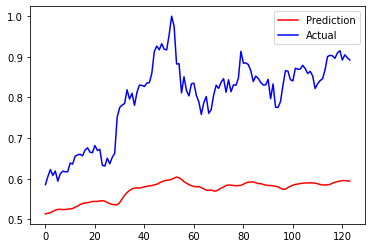

In [22]:
# copy paste
plt.plot(newp_rnn,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

## Tuning

- Anzahl Layer
- Parameter
- Anzahl Trainingsdurchläufe

### Build Model

### Fit Model

### Denormalize Data

### Evaluate Data

### Visualization


## Arbeitspaket 4: LSTM

### Build Model

In [23]:
# Hier wird das neuronale Netz mit seinen Schichten gebaut
def build_model_lstm(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [24]:
# window haben wir einfach aus dem Beispiel übernommen
window = 22
# Methode von oben aufrufen
X_train, y_train, X_test, y_test = load_data(df_apple, window)
print (X_train[0], y_train[0])
print(len(X_train))

[[0.04576853 0.04414991 0.04467816 0.04058979]
 [0.04783212 0.04471483 0.0450942  0.03578986]
 [0.04107656 0.03878326 0.03776724 0.02978991]
 [0.03753584 0.03411191 0.03721253 0.03243393]
 [0.03779651 0.03487235 0.0392465  0.03223055]
 [0.03751411 0.03732754 0.04098    0.03503731]
 [0.04127205 0.03765345 0.0427135  0.03385764]
 [0.03820922 0.03480718 0.03862244 0.03139665]
 [0.03684073 0.03858773 0.04019415 0.03530169]
 [0.04035972 0.03700162 0.04093378 0.03241357]
 [0.03694935 0.03337317 0.03547902 0.02822379]
 [0.02739161 0.02976644 0.02896105 0.02840686]
 [0.03421236 0.03080934 0.02990871 0.02303741]
 [0.02293856 0.02324824 0.02403792 0.0189493 ]
 [0.01885481 0.01838131 0.01608691 0.01030525]
 [0.01857243 0.01616513 0.01684966 0.01134261]
 [0.01948475 0.01605648 0.01819021 0.01453578]
 [0.02291686 0.01959805 0.02165722 0.01744421]
 [0.02241724 0.02068442 0.01809778 0.01221712]
 [0.01729082 0.01914178 0.01449207 0.01654927]
 [0.01346771 0.0131233  0.01361378 0.01168829]
 [0.01826832 

In [25]:
# Methode von oben aufrufen
model_lstm = build_model_lstm([4,window,1]) 

Compilation Time :  0.003553152084350586


### Fit Model

In [26]:
model_lstm.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Epoch 1/90
2/2 [==============================] - 3s 861ms/step - loss: 0.0373 - accuracy: 0.0013 - val_loss: 0.2144 - val_accuracy: 0.0000e+00
Epoch 2/90
2/2 [==============================] - 1s 371ms/step - loss: 0.0344 - accuracy: 6.6667e-04 - val_loss: 0.1906 - val_accuracy: 0.0000e+00
Epoch 3/90
2/2 [==============================] - 1s 366ms/step - loss: 0.0291 - accuracy: 0.0013 - val_loss: 0.1269 - val_accuracy: 0.0000e+00
Epoch 4/90
2/2 [==============================] - 1s 371ms/step - loss: 0.0143 - accuracy: 0.0013 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 5/90
2/2 [==============================] - 1s 383ms/step - loss: 0.0082 - accuracy: 0.0013 - val_loss: 0.0336 - val_accuracy: 0.0000e+00
Epoch 6/90
2/2 [==============================] - 1s 372ms/step - loss: 0.0065 - accuracy: 6.6667e-04 - val_loss: 0.0645 - val_accuracy: 0.0000e+00
Epoch 7/90
2/2 [==============================] - 1s 371ms/step - loss: 0.0049 - accuracy: 6.6667e-04 - val_loss: 0.0785 - val_a

Epoch 56/90
2/2 [==============================] - 1s 373ms/step - loss: 3.3359e-04 - accuracy: 6.6667e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 57/90
2/2 [==============================] - 1s 381ms/step - loss: 3.3048e-04 - accuracy: 0.0013 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 58/90
2/2 [==============================] - 1s 378ms/step - loss: 3.0792e-04 - accuracy: 0.0013 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 59/90
2/2 [==============================] - 1s 378ms/step - loss: 3.1922e-04 - accuracy: 6.6667e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 60/90
2/2 [==============================] - 1s 378ms/step - loss: 2.9135e-04 - accuracy: 0.0013 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 61/90
2/2 [==============================] - 1s 381ms/step - loss: 3.1477e-04 - accuracy: 0.0013 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 62/90
2/2 [==============================] - 1s 382ms/step - loss: 3.0585e-04 - accuracy: 0.

In [32]:

# copy pasted -> ist das relevant?? Frage an Herr Kohl

# print(X_test[-1])
diff=[]
ratio=[]
p_lstm = model_lstm.predict(X_test)
print(p_lstm.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p_lstm[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1])

(124, 1)


### Denormalize Data

In [28]:
# Methode von oben aufrufen
newp_lstm = denormalize(df_apple, p_lstm)
newy_test = denormalize(df_apple, y_test)

### Evaluate Model

In [29]:
# Methode von oben aufrufen
model_score(model_lstm, X_train, y_train, X_test, y_test)

Train Score: 0.00057 MSE (0.02 RMSE)
Test Score: 0.00874 MSE (0.09 RMSE)


(0.0005713300197385252, 0.008735009469091892)

### Visualization

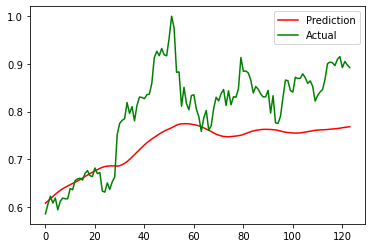

In [30]:
# copy paste
plt.plot(newp_lstm,color='red', label='Prediction')
plt.plot(newy_test,color='green', label='Actual')
plt.legend(loc='best')
plt.show()

## Tuning

- Anzahl Layer
- Parameter
- Anzahl Trainingsdurchläufe

### Build Model

### Fit Model

### Denormalize Data

### Evaluate Model

### Visualization

# To Do
- Arbeitspaket 1: Datenvisualisierung
- Tuning

# Quellen

Main Source: 
- https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook

SimpleRNN Layer: 
- https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc

as_matrix neue Methode: 
- https://pandas.pydata.org/pandas-docs/version/0.25.1/reference/api/pandas.DataFrame.as_matrix.html
